In [1]:
import jax.numpy as jnp
import jax.scipy as jsp
from jax import random
import jax
import numpy as onp
import torch
import gpytorch as gpt

import matplotlib.pyplot as plt

In [2]:
from jaxgp.utils import *
from jaxgp.kernels import RBF

from typing import NamedTuple

In [3]:
class Covars(NamedTuple):
    k_nn: jnp.ndarray
    k_mn: jnp.ndarray
    k_mm: jnp.ndarray

In [4]:
def covariance_matrices(X_split, X_ref, kernel, params) -> Covars:
    KF = CovMatrixFF(X_split[0], X_split[0], kernel, params)
    KD = CovMatrixFD(X_split[0], X_split[1], kernel, params)
    KDD = CovMatrixDD(X_split[1], X_split[1], kernel, params)

    K_NN = jnp.vstack((jnp.hstack((KF,KD)), 
                       jnp.hstack((KD.T,KDD))))
    # calculates the covariance between the training points and the reference points
    KF = CovMatrixFF(X_ref, X_split[0], kernel, params)
    KD = CovMatrixFD(X_ref, X_split[1], kernel, params)
    
    K_MN = jnp.hstack((KF,KD))

    # calculates the covariance between each pair of reference points
    K_ref = CovMatrixFF(X_ref, X_ref, kernel, params)

    return Covars(K_NN, K_MN, K_ref)

In [5]:
def fun(x, noise=0.0, key = random.PRNGKey(0)):
    return (x[:,0]**2 + x[:,1] - 11)**2 / 800.0 + (x[:,0] + x[:,1]**2 -7)**2 / 800.0 + random.normal(key,(len(x),), dtype=jnp.float32)*noise

def grad(x, noise=0.0, key = random.PRNGKey(0)):
    dx1 = 4 * (x[:,0]**2 + x[:,1] - 11) * x[:,0] + 2 * (x[:,0] + x[:,1]**2 -7)
    dx2 = 2 * (x[:,0]**2 + x[:,1] - 11) + 4 * (x[:,0] + x[:,1]**2 -7) * x[:,1]
    return jnp.vstack((dx1, dx2)).T / 800.0 + random.normal(key,x.shape, dtype=jnp.float32)*noise

In [6]:
# Interval bounds from which to choose the data points
bounds = jnp.array([-5.0, 5.0])

# How many function and derivative observations should be chosen
num_f_vals = 30
num_d_vals = 100
dims = 2

# initial seed for the pseudo random key generation
seed = 0

# create new keys and randomly sample the above interval for training features
key, subkey = random.split(random.PRNGKey(seed))
x_func = random.uniform(subkey, (num_f_vals, dims), minval=bounds[0], maxval=bounds[1])
key, subkey = random.split(key)
x_der = random.uniform(subkey, (num_d_vals, dims), minval=bounds[0], maxval=bounds[1])


num_ref_points = (num_d_vals + num_f_vals) // 10
# num_ref_points = 2
key, subkey = random.split(key)
X_ref = random.uniform(subkey, (num_ref_points, dims), minval=bounds[0], maxval=bounds[1])

# noise with which to sample the training labels
noise = 0.02
key, subkey = random.split(key)
y_func = fun(x_func,noise, subkey)
key, subkey = random.split(key)
y_der = grad(x_der, noise, subkey)

In [7]:
X_split = [x_func,x_der]
Y_train = jnp.hstack((y_func, y_der.reshape(-1)))

kernel = RBF()
kernel_params = jnp.array([1.0, 1.0])

In [8]:
jax_covs = jax.jit(covariance_matrices)(X_split, X_ref, kernel, kernel_params)

## CHECK K_NN

In [9]:
K_NN_JAX = jax_covs.k_nn

In [10]:
x = torch.Tensor(onp.array(jnp.vstack((x_func, x_der))))
torch_kernel = gpt.kernels.RBFKernelGrad()
torch_kernel.lengthscale = 1.0
K_NN_TORCH = torch_kernel(x).to_dense()

In [11]:
def cut_func(x, n_f, dims):
    funcs = x[:n_f*(dims+1)]
    ders = x[n_f*(dims+1):]
    x = torch.cat((funcs, ders[torch.fmod(torch.arange(ders.shape[0]), (dims+1)) != 0]), dim=0)
    funcs = x[:,:n_f*(dims+1)]
    ders = x[:,n_f*(dims+1):]
    x = torch.cat((funcs, ders[:,torch.fmod(torch.arange(ders.shape[1]), (dims+1)) != 0]), dim=1)
    return x

def cut_der(x, n_f, dims):
    funcs = x[:n_f*(dims+1)]
    ders = x[n_f*(dims+1):]
    x = torch.cat((funcs[::(dims+1)], ders), dim=0)
    funcs = x[:,:n_f*(dims+1)]
    ders = x[:,n_f*(dims+1):]
    x = torch.cat((funcs[:,::(dims+1)], ders), dim=1)
    return x

In [12]:
K_NN_TORCH = cut_der(cut_func(K_NN_TORCH, num_f_vals, dims), num_f_vals, dims)
K_NN_TORCH = K_NN_TORCH.detach().numpy()

In [13]:
print(onp.allclose(K_NN_JAX, K_NN_TORCH))
print(onp.max(onp.abs(K_NN_JAX-K_NN_TORCH)))

True
1.9073486e-06


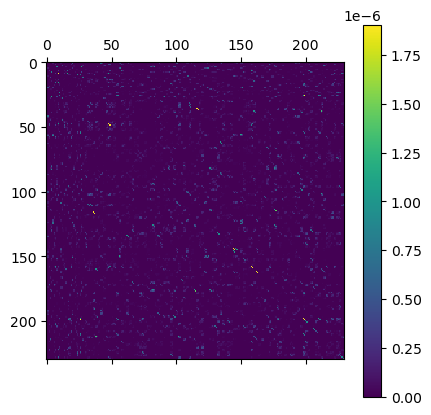

In [14]:
plt.matshow(onp.abs(K_NN_JAX-K_NN_TORCH))
plt.colorbar()

## CHECK K_MM

In [15]:
K_MM_JAX = jax_covs.k_mm

In [16]:
torch_kernel = gpt.kernels.RBFKernel()
torch_kernel.lengthscale = 1.0
x_ref = torch.Tensor(onp.array(X_ref))
K_MM_TORCH = torch_kernel(x_ref)
K_MM_TORCH = K_MM_TORCH.detach().numpy()

In [17]:
print(onp.allclose(K_MM_JAX, K_MM_TORCH))
print(onp.max(onp.abs(K_MM_JAX-K_MM_TORCH)))

True
9.536743e-07


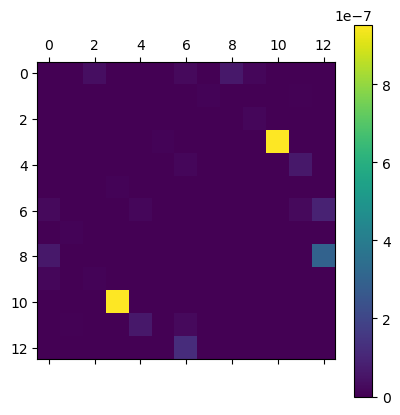

In [18]:
plt.matshow(onp.abs(K_MM_JAX-K_MM_TORCH))
plt.colorbar()

## CHECK K_MN

In [19]:
def cut_func(x, n_f, dims):
    funcs = x[:,:n_f*(dims+1)]
    ders = x[:,n_f*(dims+1):]
    x = torch.cat((funcs, ders[:,torch.fmod(torch.arange(ders.shape[1]), (dims+1)) != 0]), dim=1)
    return x

def cut_der(x, n_f, dims):
    x = x[::(dims+1)]
    funcs = x[:,:n_f*(dims+1)]
    ders = x[:,n_f*(dims+1):]
    x = torch.cat((funcs[:,::(dims+1)], ders), dim=1)
    return x

In [20]:
K_MN_JAX = jax_covs.k_mn

In [21]:
x = torch.Tensor(onp.array(jnp.vstack((x_func, x_der))))
x_ref = torch.Tensor(onp.array(X_ref))
torch_kernel = gpt.kernels.RBFKernelGrad()
torch_kernel.lengthscale = 1.0
K_MN_TORCH = torch_kernel(x_ref,x).to_dense()

In [22]:
K_MN_TORCH = cut_der(cut_func(K_MN_TORCH, num_f_vals, dims), num_f_vals, dims)
K_MN_TORCH = K_MN_TORCH.detach().numpy()

In [23]:
print(onp.allclose(K_MN_JAX, K_MN_TORCH))
print(onp.max(onp.abs(K_MN_JAX-K_MN_TORCH)))

True
9.536743e-07


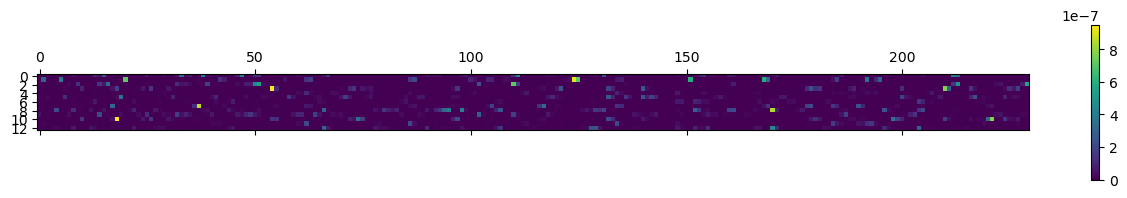

In [24]:
plt.matshow(onp.abs(K_MN_JAX-K_MN_TORCH))
plt.colorbar()

## CHECK RANKS

In [27]:
print(f"K_NN.shape = {K_NN_JAX.shape}, K_NN.rank = {jnp.linalg.matrix_rank(K_NN_JAX)}")
print(f"K_MN.shape = {K_MN_JAX.shape}, K_MN.rank = {jnp.linalg.matrix_rank(K_MN_JAX)}")
print(f"K_MM.shape = {K_MM_JAX.shape}, K_MM.rank = {jnp.linalg.matrix_rank(K_MM_JAX)}")

K_NN.shape = (230, 230), K_NN.rank = 189
K_MN.shape = (13, 230), K_MN.rank = 13
K_MM.shape = (13, 13), K_MM.rank = 13


## MATRIX PLOTS

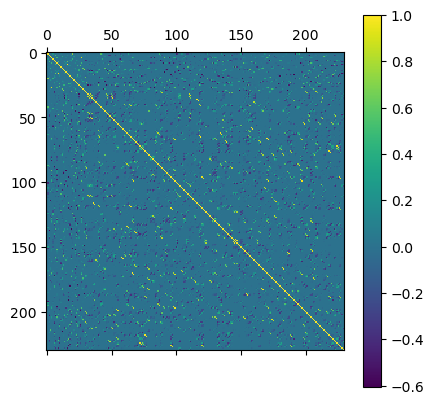

In [ ]:
plt.matshow(K_NN_JAX)
plt.colorbar()

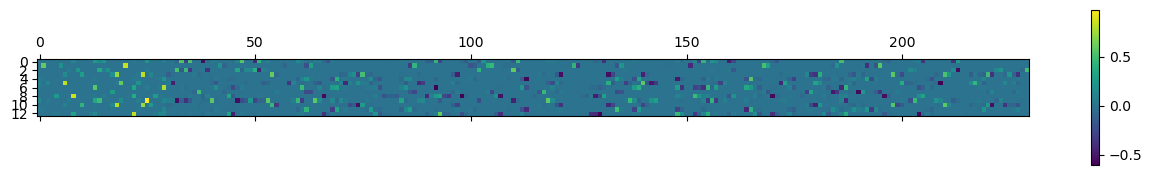

In [ ]:
plt.matshow(K_MN_JAX)
plt.colorbar()

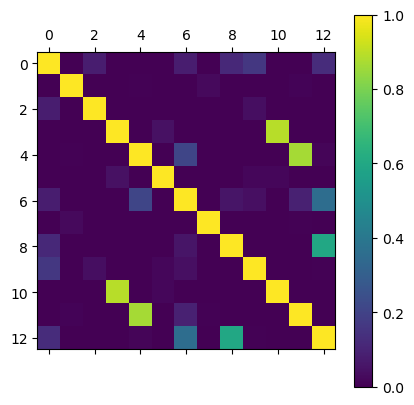

In [ ]:
plt.matshow(K_MM_JAX)
plt.colorbar()

## SPARSE RATES

In [ ]:
def check_sparsity(A, tol=1e-5):
    sparse = jnp.where(jnp.less(jnp.abs(A), tol), 1, 0)
    return jnp.mean(sparse)

In [ ]:
tol = 1e-3

print(f"K_NN_JAX: {check_sparsity(K_NN_JAX, tol)}")
print(f"K_MN_JAX: {check_sparsity(K_MN_JAX, tol)}")
print(f"K_MM_JAX: {check_sparsity(K_MM_JAX, tol)}")

K_NN_JAX: 0.6396597027778625
K_MN_JAX: 0.629431426525116
K_MM_JAX: 0.6153846383094788


## FULL GPR MODEL PYTORCH

In [ ]:
def cut_func(x, n_f, dims):
    funcs = x[:n_f*(dims+1)]
    ders = x[n_f*(dims+1):]
    x = torch.cat((funcs, ders[torch.fmod(torch.arange(ders.shape[0]), (dims+1)) != 0]), dim=0)
    funcs = x[:,:n_f*(dims+1)]
    ders = x[:,n_f*(dims+1):]
    x = torch.cat((funcs, ders[:,torch.fmod(torch.arange(ders.shape[1]), (dims+1)) != 0]), dim=1)
    return x

def cut_der(x, n_f, dims):
    funcs = x[:n_f*(dims+1)]
    ders = x[n_f*(dims+1):]
    x = torch.cat((funcs[::(dims+1)], ders), dim=0)
    funcs = x[:,:n_f*(dims+1)]
    ders = x[:,n_f*(dims+1):]
    x = torch.cat((funcs[:,::(dims+1)], ders), dim=1)
    return x

In [ ]:
class GPModelWithDerivatives(gpt.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModelWithDerivatives, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpt.means.ConstantMeanGrad()
        self.base_kernel = gpt.kernels.RBFKernelGrad()
        self.covar_module = gpt.kernels.ScaleKernel(self.base_kernel)

    def forward(self, x):
        mean_x = self.mean_module(x)
        print(mean_x.shape)
        covar_x = self.covar_module(x)
        print(covar_x.shape)
        return gpt.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [ ]:
x = torch.Tensor(onp.array(jnp.vstack((x_func, x_der))))

In [ ]:
likelihood = gpt.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = GPModelWithDerivatives(x, x, likelihood)

model.forward(x)

torch.Size([130, 3])
torch.Size([390, 390])


MultitaskMultivariateNormal(loc: torch.Size([390]))